In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, auc, roc_curve, roc_auc_score
import itertools
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, InstanceHardnessThreshold
import catboost as cat
from  lightgbm import LGBMClassifier
import umap


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def quality_metrics(marks, preds):
    """
    Функция выводит значения основных показателей качества обучения модели
    """
    print("Accuracy: {0:.9f}".format(accuracy_score(marks, preds)))
    print("Precision: {0:.9f}".format(precision_score(marks, preds)))
    print("Recall: {0:.9f}".format(recall_score(marks, preds)))
    print("F1: {0:.9f}".format(f1_score(marks, preds)))

In [90]:
train = pd.read_csv('HSE_dataset_train.csv', delimiter=',')
test = pd.read_csv('HSE_dataset_test_X.csv', delimiter=',')
marks = pd.read_csv('HSE_dataset_test_Y.csv', delimiter=',')
test = test.merge(marks[['Customer_ID', 'TARGET']],on='Customer_ID', how='left')


C:\Users\777\AppData\Local\Temp\ipykernel_16804\1948757962.py:1: DtypeWarning: Columns (386,387) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('HSE_dataset_train.csv', delimiter=',')


## План исследования:
1) Описание набора данных и признаков
2) Первичный анализ признаков
3) Предобработка данных
4) Визуализация
5) XGBOOST
6) CatBoost
7) Lightgbm
8) Выводы

## Описание набора данных и признаков


In [91]:
set_diff = set(train.columns).symmetric_difference(set(test.columns))
set_diff

{'DATE_OF_CROSS_SALE', 'DATE_OF_SALE', 'Sample', 'index', 'rand'}

In [92]:
len(train.columns) - 5

384

Для исследования был взят датасет предоставленный руководителем практики. Датасет представляет собой предварительно обработанные и обезличенные данные, в которых содержится информация о клиентах: выбранных для них стратегий инвестиций, различных факторов для каждого клиента, потребляемые ими продукты банковских услуг и т.п. Он разбит на тестовую и обучающую выборки и имеет 384 признака, в основном бинарные и числовые. Нас будет интересовать метка TARGET, которая соответствует дефолту клиента.

In [93]:
train= train.drop(columns=['DATE_OF_CROSS_SALE', 'DATE_OF_SALE', 'rand', 'Unnamed: 0','Customer_ID'])
test = test.drop(columns=['Sample', 'index','Unnamed: 0','Customer_ID'])

In [94]:
train.head(5)

,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Subproduct_1,Subproduct_2,Subproduct_3,Subproduct_4,...,Factor_138,Factor_139,Factor_140,Factor_141,Factor_142,Factor_137,Factor_136,Factor_135,Factor_134,Factor_143
0,0,0,0,1,0,0,0,0,0,0,...,164.82,1,1,Category_4,Category_4,Category_1,Category_2,Category_2,36,36
1,0,0,0,0,1,0,0,0,0,0,...,193.11,1,1,Category_5,Category_5,Category_3,Category_1,Category_3,60,60
2,0,0,0,1,0,0,0,0,0,0,...,164.82,1,1,Category_4,Category_4,Category_4,Category_12,Category_11,60,60
3,1,0,0,0,0,0,0,0,0,0,...,209.10,1,1,Category_1,Category_1,Category_5,Category_13,Category_13,0,0
4,1,0,0,0,0,0,0,0,0,0,...,200.49,1,1,Category_1,Category_1,Category_6,Category_13,Category_13,0,0


In [95]:
test.head(5)

,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Subproduct_1,Subproduct_2,Subproduct_3,Subproduct_4,...,Factor_139,Factor_140,Factor_141,Factor_142,Factor_137,Factor_136,Factor_135,Factor_134,Factor_143,TARGET
0,0,0,1,1,0,0,0,0,0,0,...,2,2,Category_3,Category_4,Category_4,Category_10,Category_11,38.0,60.0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,1,Category_4,Category_4,Category_5,Category_12,Category_11,60.0,60.0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,1,Category_5,Category_5,Category_3,Category_9,Category_9,120.0,120.0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,1,Category_5,Category_5,Category_9,Category_9,Category_9,120.0,120.0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,1,Category_5,Category_5,Category_8,Category_1,Category_3,60.0,60.0,0


## 2)Первичный анализ признаков

In [96]:
nulls_train = pd.DataFrame(train.isnull().sum (), columns=['misses'])
nulls_test = pd.DataFrame(test.isnull().sum (), columns=['misses'])

In [97]:
nulls_test[nulls_test['misses'] > 0]

,misses
Factor_19,1
Factor_20,1
Factor_21,1
Factor_35,1148
Factor_42,21096
Factor_132,7146
Factor_133,7146
Factor_138,9
Factor_137,9
Factor_136,9


In [98]:
nulls_train[nulls_train['misses'] > 0]

,misses
Factor_19,10
Factor_20,10
Factor_21,10
Factor_35,2541
Factor_42,57174
Factor_132,11118
Factor_133,11118
Factor_138,35
Factor_137,35
Factor_136,35


Видно, что в датасете есть отсутствующие значения в некоторых признаках, т. к. данные достаточно объемные можно просто заменить на среднее по признаку отсутствующие значения. Также стоит убрать все строки из тестовой выборки, в которых отсутствуют значения метки класса. Также стоит удалить признаки, которые отсутствуют хотя бы в одной из выборок. Также можно наблюдать категориальные признаки, которые следует привести к другому виду. Так как данные обезличены (ввиду политики конфиденциальности банка) и предварительно обработаны, на данном этапе визуализация вряд ли представляется возможной. Основная задача это сравнить между собой работоспособность 3ех бустинговых методов.
Также в датасете наблюдается сильная несбалансированность целевой метки, поэтому вопрос балансировки выборок стоит рассмотреть подробнее.
Пропущенные значения у выборок очень схожи, это некоторые значения факторов. Следует узнать: если зависимость между отсутствием значения и влияние на это метки класса.

## 3) Предобработка данных

Категориальные переменные из factor: 34, 42, 133, 141, 142, 137, 136, 135 преобразуем в числовые. Конечно бинарные признаки работали бы лучше, но тогда пришлось бы ввести свыше 60 новых признаков. Современные алгоритмы позволяют работать с разными типами признаков, поэтому решено было остановиться на данном подходе. Нормировка не требуется, т. к. используются бустинговые методы основанные на деревьях решений.


In [99]:
category_dict = {'Category_'+ f'{i}':i for i in range(0,90)}

In [100]:
train = train.replace(list(category_dict.keys()),list(category_dict.values()))

In [101]:
test = test.replace(list(category_dict.keys()),list(category_dict.values()))

Буду проверять только факторы 35, 42, 132, 133, т. к. в них присутствует достаточно большое количество пропущенных значений.


In [102]:
sub_factors = train[['Factor_35','Factor_42','Factor_132', 'Factor_133', 'TARGET']]

In [103]:
sub_factors.groupby(['TARGET'])[['Factor_35','Factor_42','Factor_132', 'Factor_133']].apply(lambda x: x.isnull().sum())

,Factor_35,Factor_42,Factor_132,Factor_133
TARGET,,,,
0,2531,56918,11048,11048
1,10,256,70,70


На всякий случай добавим бинарные признаки отсутствия данных по этим столбцам. Для остальных значений проверим распределение и выберем на что их заменить.

In [104]:
train['Factor_35_is_NaN'] = np.where(train['Factor_35'].isnull(), 1,0)
train['Factor_42_is_NaN'] = np.where(train['Factor_42'].isnull(), 1,0)
train['Factor_132_is_NaN'] = np.where(train['Factor_132'].isnull(), 1,0)
train['Factor_133_is_NaN'] = np.where(train['Factor_133'].isnull(), 1,0)

In [105]:
test['Factor_35_is_NaN'] = np.where(test['Factor_35'].isnull(), 1,0)
test['Factor_42_is_NaN'] = np.where(test['Factor_42'].isnull(), 1,0)
test['Factor_132_is_NaN'] = np.where(test['Factor_132'].isnull(), 1,0)
test['Factor_133_is_NaN'] = np.where(test['Factor_133'].isnull(), 1,0)

In [106]:
train = train.replace(['нет данных'], None)
test = test.replace(['нет данных'], None)
train[['Factor_134','Factor_143']] = train[['Factor_134','Factor_143']].astype(float)
test[['Factor_134','Factor_143']] = test[['Factor_134','Factor_143']].astype(float)
train[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']] = train[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']]. fillna(train[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']].mean())
test[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']] = test[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']]. fillna(test[['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']].mean())
train[['Factor_134','Factor_143']] = train[['Factor_134','Factor_143']].astype(int)
test[['Factor_134','Factor_143']] = test[['Factor_134','Factor_143']].astype(int)
features = list(train.columns)
features.remove('TARGET')

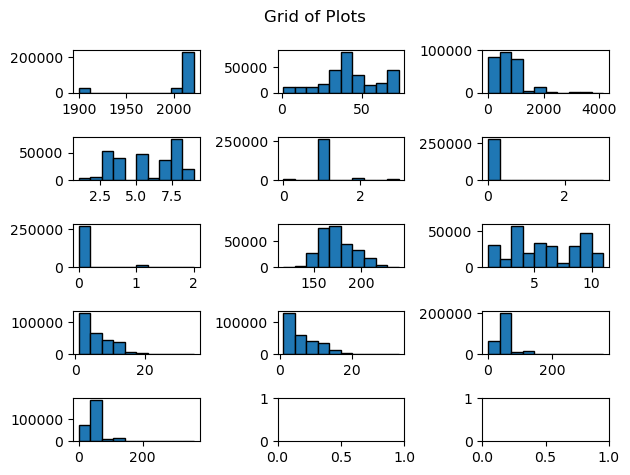

In [107]:
pl_list = ['Factor_35','Factor_42','Factor_132', 'Factor_133','Factor_19','Factor_20','Factor_21','Factor_138','Factor_137','Factor_136','Factor_135','Factor_134','Factor_143']
fig, axs = plt.subplots(nrows= 5 , ncols= 3 )

fig. suptitle('Grid of Plots')
k=0
z=0
for i in pl_list:
    axs[z, k].hist(train[i], edgecolor='black')
    k += 1
    if k > 2:
        k = 0
        z += 1
        if z > 5:
            break
fig.tight_layout()


Как видно выше из распределений, сильного разбега между значениями не наблюдается, поэтому отсутствующие значения можно заменить на средние.

Теперь следует решить проблему балансировки выборок. Дубликатов нет, поэтому существуют три возможных подхода: наращивание образцов с минорной меткой, уменьшение образцов с превалирующей меткой и установка больших весов и штрафов для минорной метки в процессе обучения модели. Также возможно комбинировать несколько вышеописанных подходов. Методы бустинга достаточно хорошо работают с несбалансированными данными, а также имеют гибко настраиваемые гиперпараметры. В этой задаче я буду применять все подходы, а затем выявлю лучший из них.

## 4) Визуализация данных

Для визуализации исходных данных буду использовать метод umap. Он объединяет в себе скорость работы метода главных компонент и эффективное преобразование, без нарушения целостности данных, метода tsne.

In [108]:
train_sample = train.sample(60000)

In [109]:
X, y = train_sample.drop('TARGET', axis=1), train_sample[['TARGET']].values.flatten()

In [110]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())

In [ ]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=80, n_components=2, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

Визуализация не дала явного представления о разделении данных на кластеры. Минорный класс сосредоточен в середине, как и первалирующий класс.

## 5) XGBOOST

## Наращивание минорной метки

Дальше я буду проводить исследование по следующему алгоритму: сначала наращивание минорных меток, визуализация получившихся данных, обучение без подбора параметров, обучение с подбором параметров, расчет показателей качества классификации и построение confusion matrix.
Для подбора параметров буду использовать кросс валидацию и RandomizedSearchCV, который делает то же самое, что и GridSearch, но подбирает параметры случайным образом n-ое количество итераций, а не все возможные комбинации.
Затем проделаю те же действия для сокращения доминирующих меток и для исходного датасета.

Для увелечения малого класса будет использоваться метод SMOTE с его разновидностями и ADASYN. Его идея такова: увеличить малый класс за счёт представителей выпуклых комбинаций пар. В методе SMOTE для точки малого класса выбирается один из k ближайших соседей и на отрезке между ними случайно выбирается новый объект. Есть разные модификации метода, например такие, в которых все точки делятся на группы, в зависимости от процента «чужих» в окрестности (от этого зависит вероятность порождения нового объекта).
Также рассматривался наивный метод RandomOverSampler, который просто дублирует значения минорной метки.
ADASYN отличается от SMOTE тем, что основное внимание уделяется генерации выборок рядом с исходными выборками, которые ошибочно классифицированы с использованием классификатора k-ближайших соседей.
                                 ![рис.1](pic_disbalance18-1.png)


## SMOTE

In [112]:
dataset = pd.concat([train, test], ignore_index=True)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)

In [114]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
dspre = pd.concat([X_train_sm, y_train_sm],axis=1 )
X_train, X_odd, y_train, y_odd = train_test_split(
    dspre[features], dspre['TARGET'], test_size=0.5, stratify=dspre['TARGET'], random_state=123
)

In [115]:
train_sample = pd.concat([X_train, y_train], axis=1).sample(40000)

In [116]:
X, y = train_sample.drop('TARGET', axis=1), train_sample[['TARGET']].values.flatten()

C:\Users\777\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


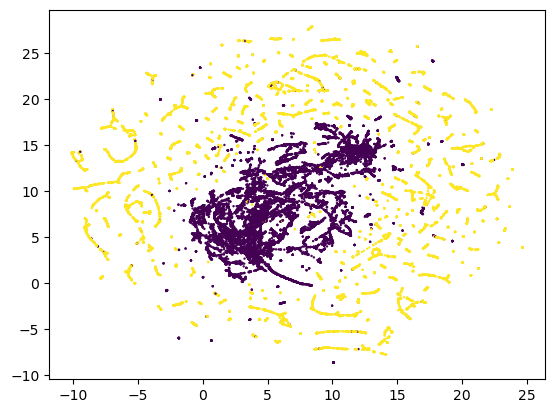

In [25]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

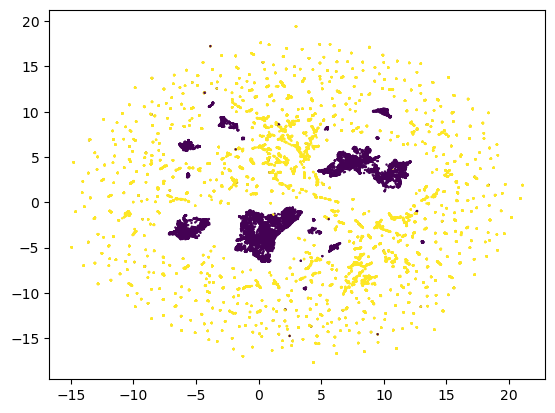

In [26]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

C:\Users\777\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<AxesSubplot:>

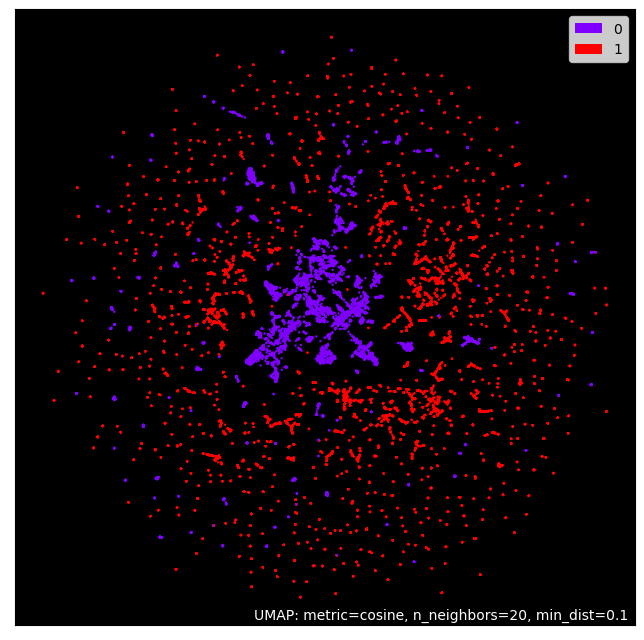

In [27]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=20, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

После балансировки тренировочной выборки на рисунке видно скопление нулей ближе к центру и россыпь единиц вокруг этого центра.

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.01, 'tree_method': 'gpu_hist'}
num_rounds = 700
watchlist = [(dtrain, "train"), (dtest, "test")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

Accuracy: 0.944477480
Precision: 0.032801418
Recall: 0.356454721
F1: 0.060074687
Confusion matrix, without normalization
[[98290  5455]
 [  334   185]]


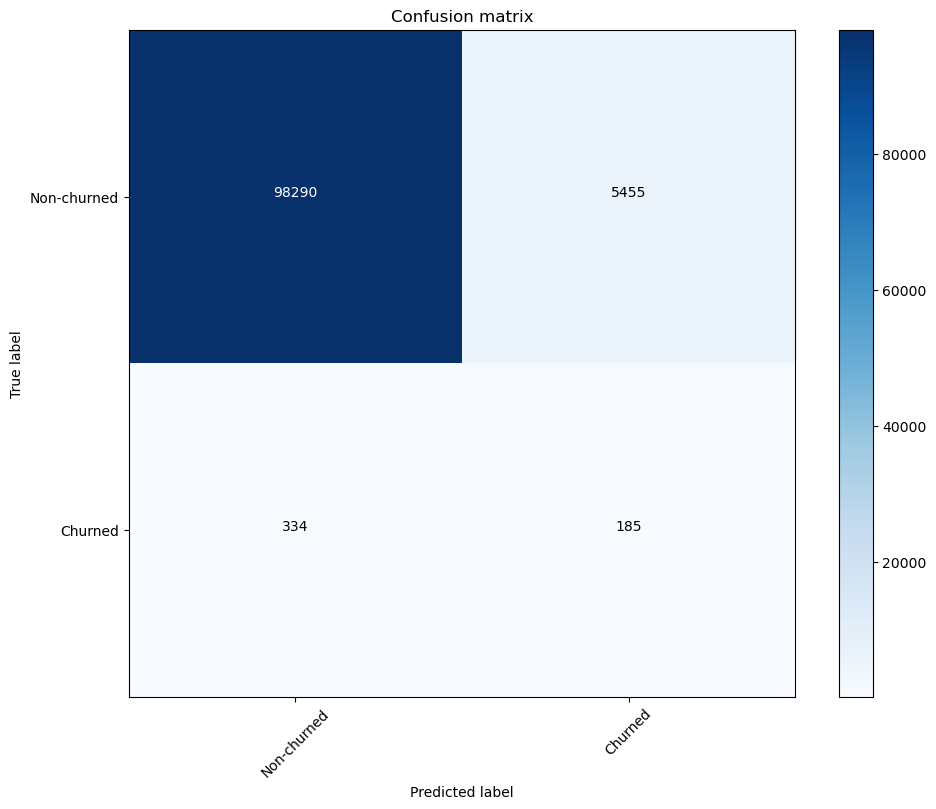

0    103745
1       519
Name: TARGET, dtype: int64

In [118]:
preds_prob = xgb_model.predict(dtest)
predicted_labels = preds_prob > 0.5
quality_metrics(y_test, predicted_labels)
cnf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

In [85]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 10.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [1, 2, 3, 4]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring=scoring,
                                   refit='f1',
                                   cv=kfold,
                                   verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is',
      round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [119]:
bparm = {'scale_pos_weight': 80, 'reg_lambda': 1e-01, 'reg_alpha': 1e-02, 'objective': 'binary:logistic', 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.4,
'tree_method': 'gpu_hist'}


In [ ]:
num_rounds = 600

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.05).astype("int")

Accuracy: 0.989785544
Precision: 0.245335821
Recall: 0.506743738
F1: 0.330609679
Confusion matrix, without normalization
[[102936    809]
 [   256    263]]


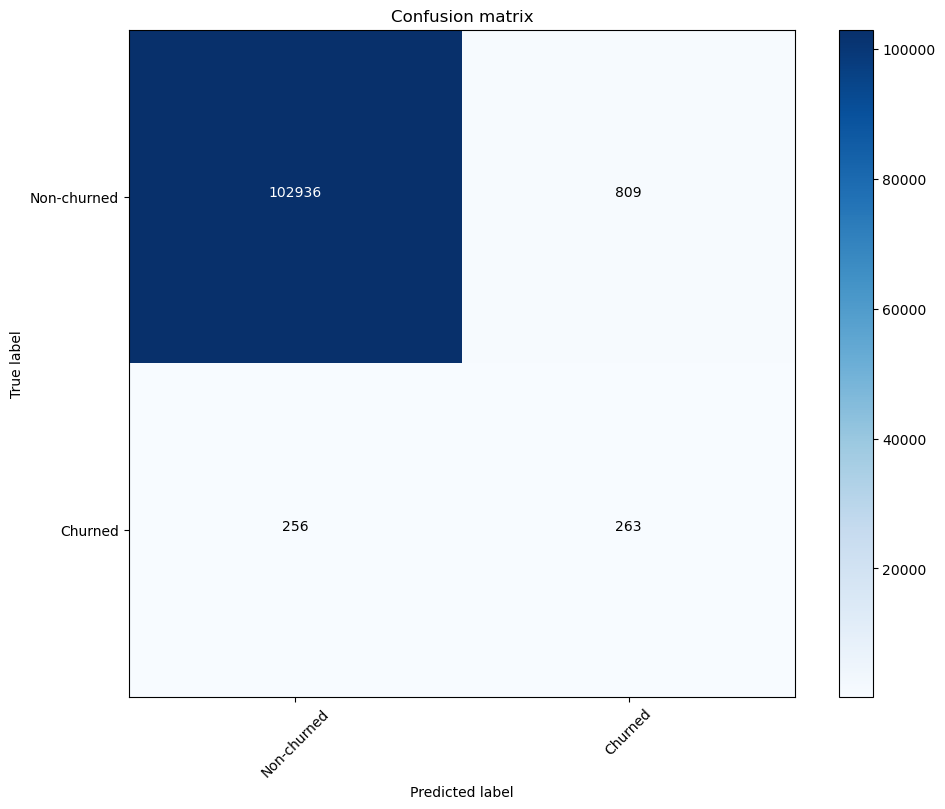

0    103745
1       519
Name: TARGET, dtype: int64

In [121]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

## ADASYN

In [122]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
dspre = pd.concat([X_resampled, y_resampled],axis=1 )
X_train, X_odd, y_train, y_odd = train_test_split(
    dspre[features], dspre['TARGET'], test_size=0.5, stratify=dspre['TARGET'], random_state=123
)

In [123]:
train_sample = pd.concat([X_train, y_train], axis=1).sample(40000)

In [124]:
X, y = train_sample.drop('TARGET', axis=1), train_sample[['TARGET']].values.flatten()

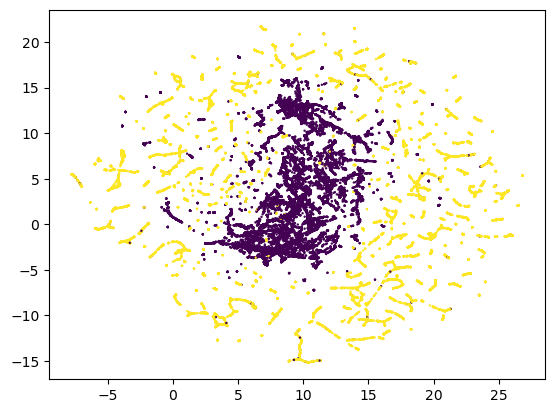

In [55]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

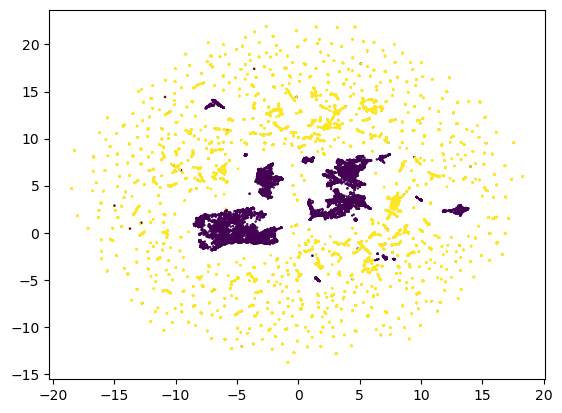

In [56]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

C:\Users\777\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<AxesSubplot:>

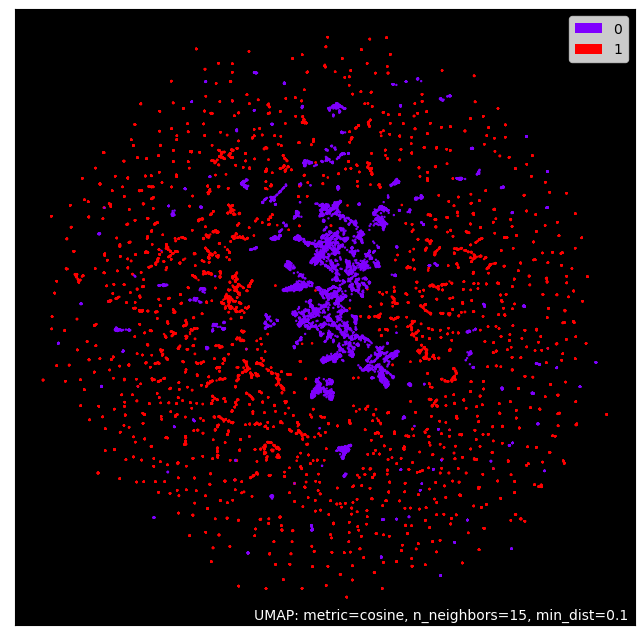

In [57]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=15,n_components=2, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

После балансировки тренировочной выборки на рисунке видно скопление нулей ближе к центру и россыпь единиц вокруг этого центра.

In [125]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [126]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.01, 'tree_method': 'gpu_hist'}
num_rounds = 250

In [ ]:
watchlist = [(dtrain, "train"), (dtest, "test")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

In [128]:
preds_prob = xgb_model.predict(dtest)
predicted_labels = preds_prob > 0.5
quality_metrics(y_test, predicted_labels)

Accuracy: 0.897279982
Precision: 0.021054610
Recall: 0.431599229
F1: 0.040150565


Confusion matrix, without normalization
[[93330 10415]
 [  295   224]]


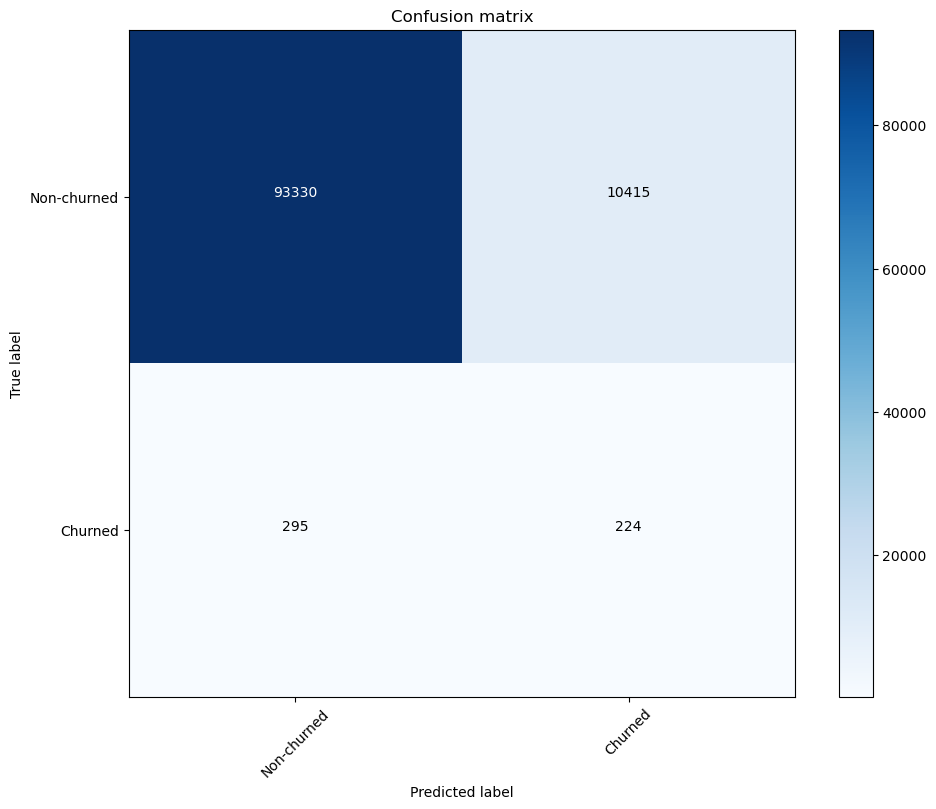

0    103745
1       519
Name: TARGET, dtype: int64

In [129]:
cnf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

In [130]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 10.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [1, 2, 3, 4]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [131]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                           param_distributions=param_grid,
                           n_iter=50,
                           scoring=scoring,
                           refit='f1',
                           cv=kfold,
                           verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START colsample_bytree=0.4, eval_metric=logloss, gamma=0.2, learning_rate=1, max_depth=12, objective=binary:logistic, reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=2
[CV 1/3; 1/50] END colsample_bytree=0.4, eval_metric=logloss, gamma=0.2, learning_rate=1, max_depth=12, objective=binary:logistic, reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=2; f1: (test=0.998) total time=   4.0s
[CV 2/3; 1/50] START colsample_bytree=0.4, eval_metric=logloss, gamma=0.2, learning_rate=1, max_depth=12, objective=binary:logistic, reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=2
[CV 2/3; 1/50] END colsample_bytree=0.4, eval_metric=logloss, gamma=0.2, learning_rate=1, max_depth=12, objective=binary:logistic, reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=2; f1: (test=0.998) total time=   2.7s
[CV 3/3; 1/50] START colsample_bytree=0.4, eval_metric=logloss, gamma=0.2, learning_rate=1, max_depth=12, objective=binary:logistic,

KeyboardInterrupt: 

In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [ ]:
bparm = {'scale_pos_weight': 12, 'reg_lambda': 1e-05, 'reg_alpha': 1e-05, 'objective': 'binary:logistic', 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.5, 'tree_method':'gpu_hist', 'max_delta_step':1}


In [ ]:
"""weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5"""
num_rounds = 600

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

## SMOTESVM

In [ ]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
X_resampled, y_resampled = SVMSMOTE().fit_resample(X_train, y_train)
dspre = pd.concat([X_resampled, y_resampled],axis=1 )
X_train, X_odd, y_train, y_odd = train_test_split(
    dspre[features], dspre['TARGET'], test_size=0.5, stratify=dspre['TARGET'], random_state=123
)

In [ ]:
train_sample = pd.concat([X_train, y_train], axis=1).sample(50000)
X, y = train_sample.drop('TARGET', axis=1), train_sample[['TARGET']].values.flatten()

C:\Users\777\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


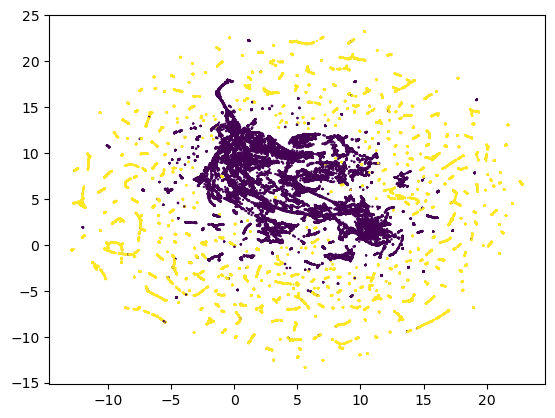

In [77]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

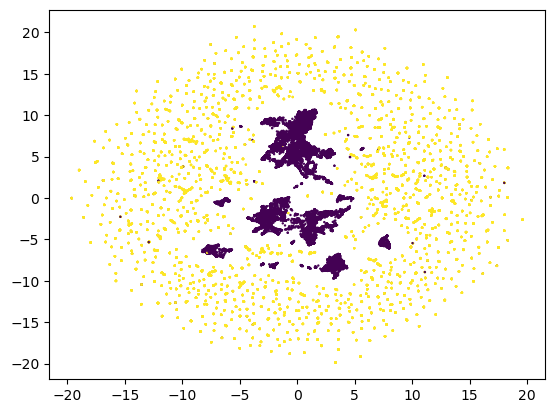

In [78]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [ ]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=10,n_components=2, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.01, 'tree_method': 'gpu_hist'}
num_rounds = 250
watchlist = [(dtrain, "train"), (dtest, "test")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

Accuracy: 0.939710734
Precision: 0.028762870
Recall: 0.339113680
F1: 0.053028020
Confusion matrix, without normalization
[[97802  5943]
 [  343   176]]


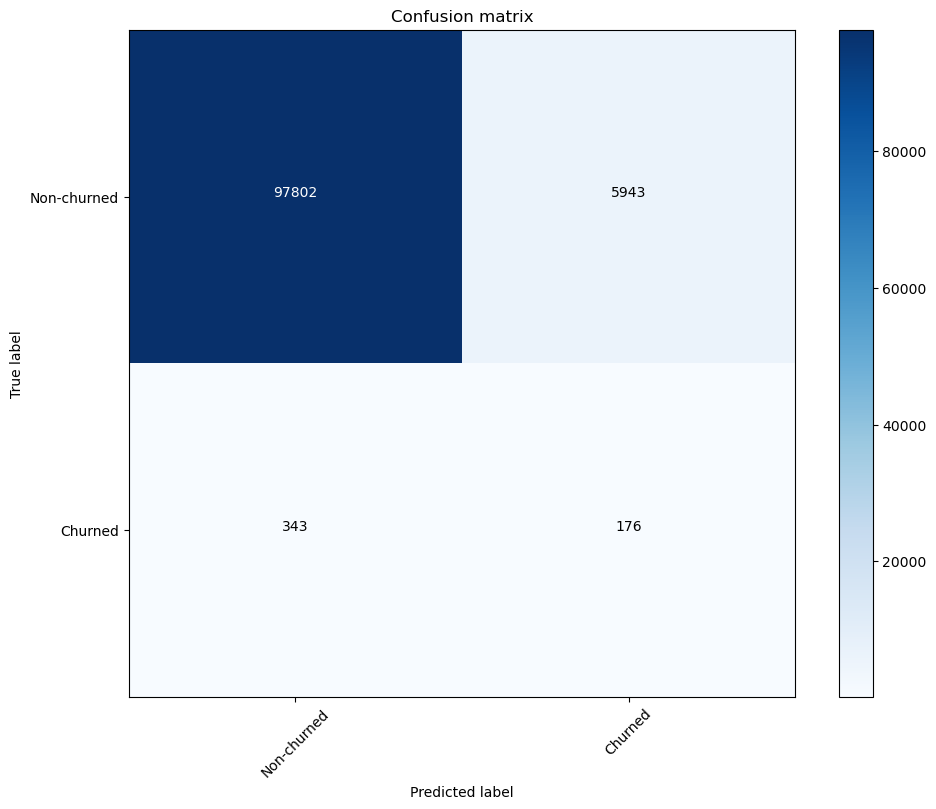

0    103745
1       519
Name: TARGET, dtype: int64

In [81]:
preds_prob = xgb_model.predict(dtest)
predicted_labels = preds_prob > 0.5
quality_metrics(y_test, predicted_labels)
cnf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

In [83]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 10.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [1, 2, 3, 4]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                           param_distributions=param_grid,
                           n_iter=50,
                           scoring=scoring,
                           refit='f1',
                           cv=kfold,
                           verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [91]:
bparm = {'scale_pos_weight': 30, 'reg_lambda': 1e-05, 'reg_alpha': 0.1, 'objective': 'binary:logistic', 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.2, 'eval_metric': 'logloss', 'colsample_bytree': 0.8, 'tree_method': 'gpu_hist', 'max_delta_step':1}

In [ ]:
num_rounds = 400

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

## BorderlineSMOTE

In [97]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train)
dspre = pd.concat([X_resampled, y_resampled],axis=1 )
X_train, X_odd, y_train, y_odd = train_test_split(
    dspre[features], dspre['TARGET'], test_size=0.5, stratify=dspre['TARGET'], random_state=123
)

In [98]:
train_sample = pd.concat([X_train, y_train], axis=1).sample(10000)
X, y = train_sample.drop('TARGET', axis=1), train_sample[['TARGET']].values.flatten()

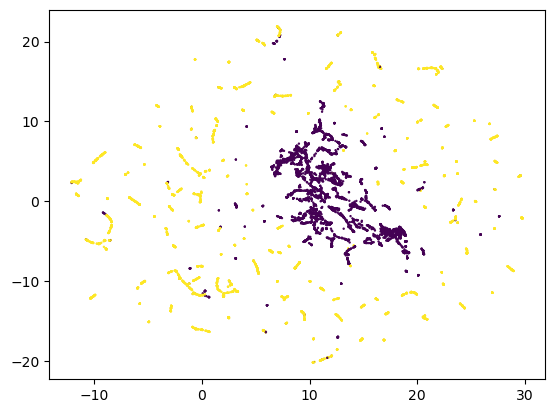

In [99]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

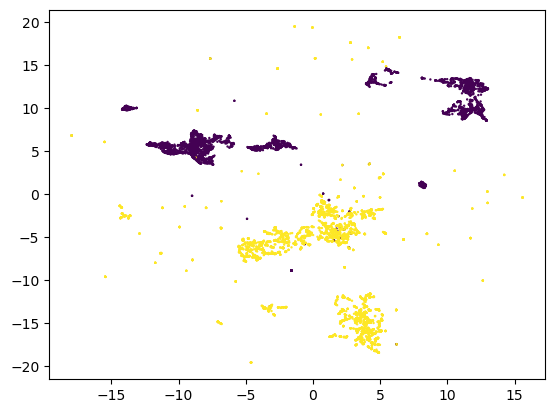

In [100]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

C:\Users\777\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<AxesSubplot:>

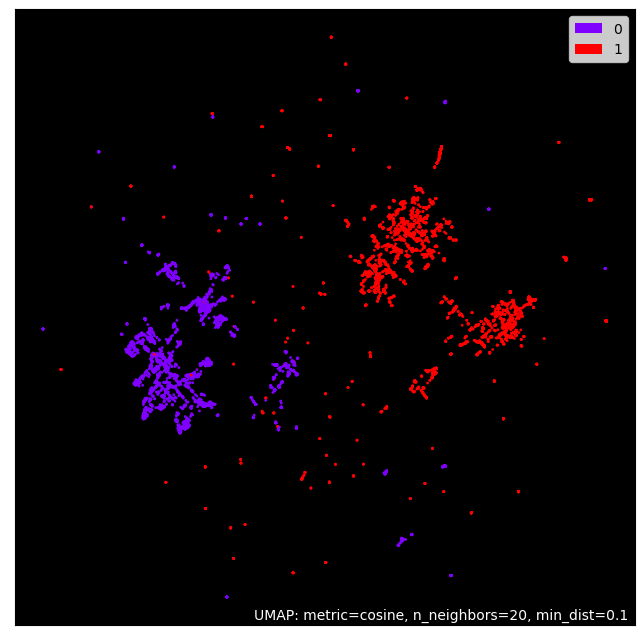

In [101]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=20,n_components=2, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

Здесь уже наблюдаем другую картину: скопление нулей в одной половине и единиц в другой.

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.01, 'tree_method': 'gpu_hist'}
num_rounds = 250
watchlist = [(dtrain, "train"), (dtest, "test")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)
preds_prob = xgb_model.predict(dtest)
predicted_labels = preds_prob > 0.5


In [ ]:
quality_metrics(y_test, predicted_labels)
cnf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

In [103]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 10.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [1, 2, 3, 4]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                                   param_distributions=param_grid,
                                   n_iter=50,
                                   scoring=scoring,
                                   refit='f1',
                                   cv=kfold,
                                   verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is',
      round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [112]:
bparm = {'scale_pos_weight': 10, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'objective': 'binary:logistic', 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.0, 'eval_metric': 'logloss', 'colsample_bytree': 0.3, 'tree_method': 'gpu_hist', 'max_delta_step':1}


In [ ]:

num_rounds = 600

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

Как видно выше, все методы не приводят к удовлетворительным результатам, поэтому сейчас попробуем наоборот-уменьшить количество превалирующих меток.

## UNDERSAMPLING

##  NEARMISS

NearMiss-3 представляет собой двухэтапный алгоритм. Во-первых, для каждой отрицательной выборки их
 M ближайших соседей будут сохранены. Затем отбираются положительные пробы, для которых среднее расстояние до N числа ближайших соседей является самым большим.
 ![рис.1](sphx_glr_plot_illustration_nearmiss_003.png)

In [114]:
nm1 = NearMiss(version=3)
X_resampled_nm1, y_resampled = nm1.fit_resample(train.drop(columns=['TARGET']), train.TARGET)
X_train, y_train = X_resampled_nm1, y_resampled

In [115]:
X, y = X_resampled_nm1, y_resampled.values.flatten()



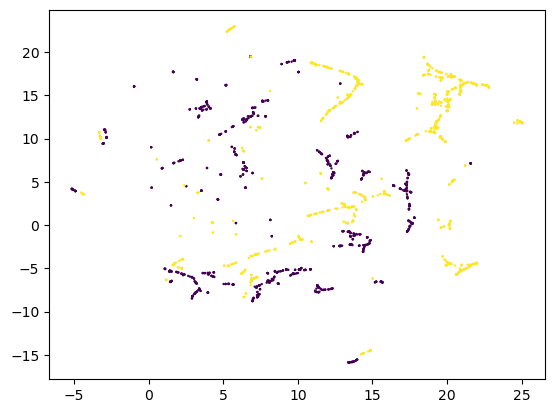

In [116]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

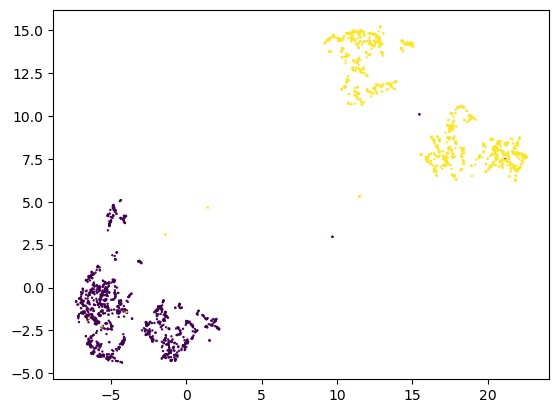

In [117]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

In [ ]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=15, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

In [119]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(test.drop(columns=['TARGET']), test.TARGET)

In [120]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/50.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [0.5, 1, 1.5, 2, 3]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                           param_distributions=param_grid,
                           n_iter=90,
                           scoring=scoring,
                           refit='f1',
                           cv=kfold,
                           verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [133]:
bparm = {'scale_pos_weight': 0.5, 'reg_lambda': 10, 'reg_alpha': 1e-05, 'objective': 'binary:logistic', 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 0.5, 'tree_method': 'gpu_hist', 'max_delta_step':1}

In [ ]:
num_rounds = 500

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

## RandomUnderSampler

RandomUnderSampler это быстрый и простой способ сбалансировать данные путем случайного выбора подмножества данных для целевых классов:

In [141]:
rus = RandomUnderSampler(random_state=0)
X_resampled_nm1, y_resampled = rus.fit_resample(train.drop(columns=['TARGET']), train.TARGET)
X_train, y_train = X_resampled_nm1, y_resampled

In [142]:
X, y = X_resampled_nm1, y_resampled.values.flatten()

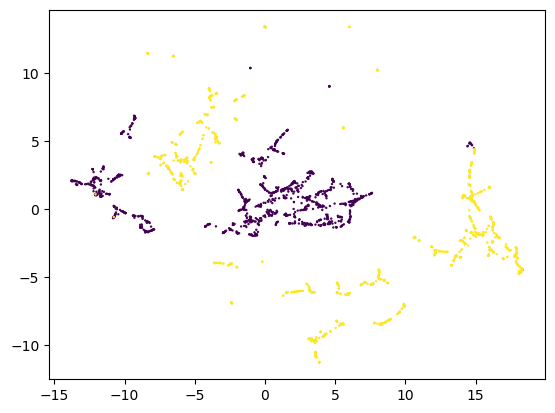

In [143]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

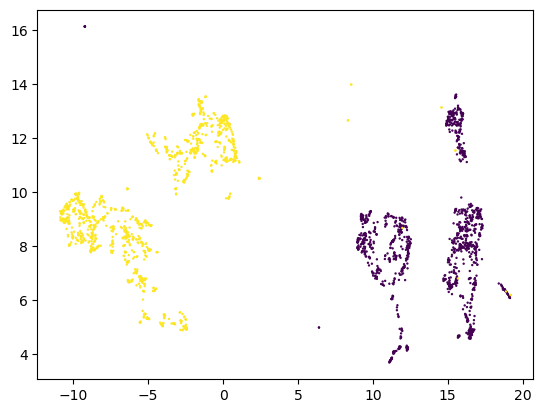

In [144]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

C:\Users\777\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<AxesSubplot:>

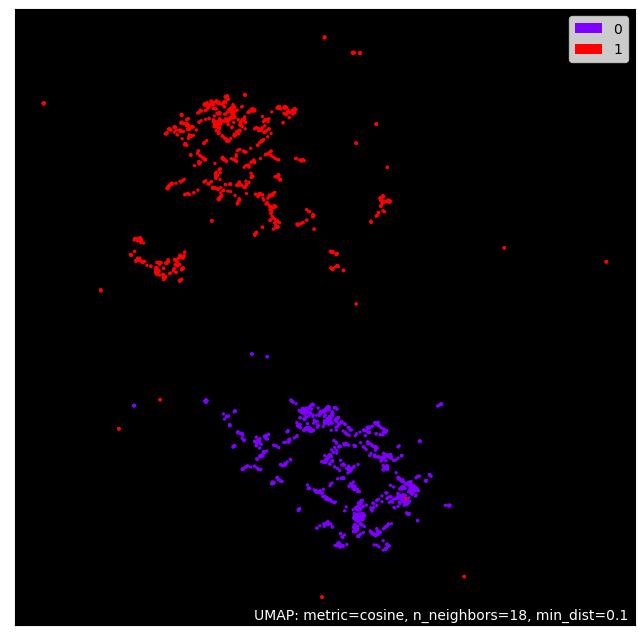

In [145]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=18, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

In [146]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [147]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 50.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["auc", "logloss"],
    'scale_pos_weight': [0.5, 1, 2, 3]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                                   param_distributions=param_grid,
                                   n_iter=90,
                                   scoring=scoring,
                                   refit='f1',
                                   cv=kfold,
                                   verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is',
      round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')


In [159]:
bparm = {'scale_pos_weight': 1, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'objective': 'binary:logistic', 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0.0, 'eval_metric': 'logloss', 'colsample_bytree': 0.7, 'tree_method': 'gpu_hist', 'max_delta_step':1}

In [ ]:
num_rounds = 600

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.8).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

## EditedNearestNeighbours

In [161]:
iht = InstanceHardnessThreshold(random_state=0, estimator=xgb.XGBClassifier(tree_method='gpu_hist'))
X_resampled_nm1, y_resampled = iht.fit_resample(train.drop(columns=['TARGET']), train.TARGET)
X_train, y_train = X_resampled_nm1, y_resampled
X, y = X_resampled_nm1, y_resampled.values.flatten()

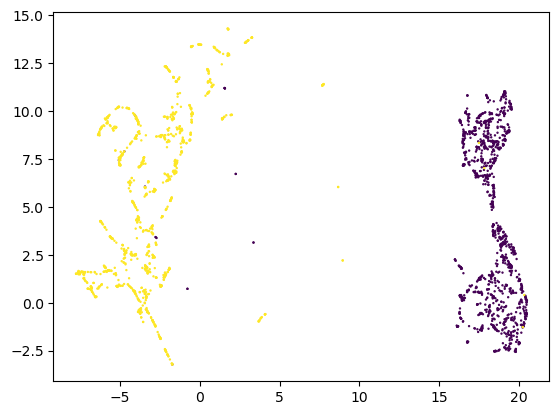

In [162]:
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())
mainfold = umap.UMAP().fit(X, y)
X_reduced = mainfold.transform(X)
X_reduced.shape
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

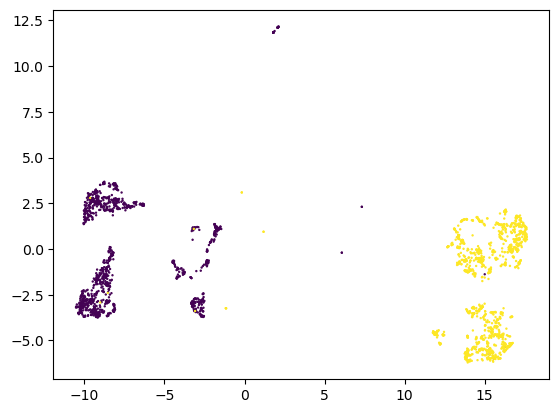

In [163]:
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

C:\Users\777\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<AxesSubplot:>

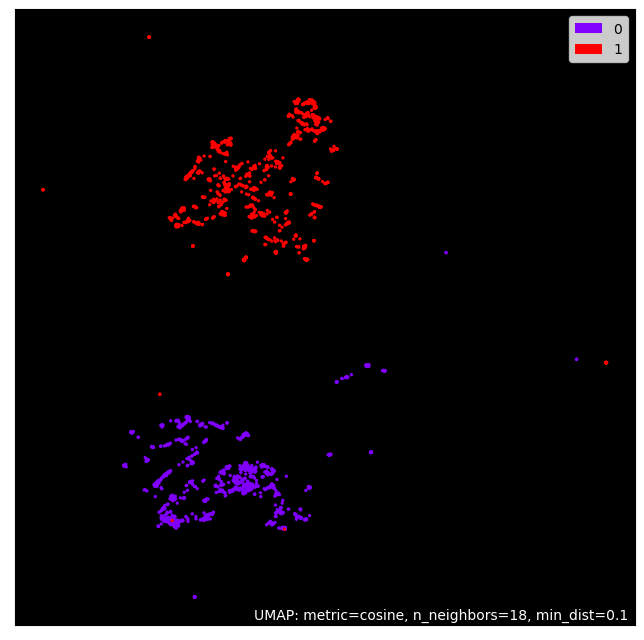

In [164]:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP(n_neighbors=18, metric="cosine", output_metric="chebyshev").fit(X, y_encoded)
umap.plot.points(manifold, labels=y, theme="darkred")

In [165]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [160]:
# Define the search space
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3, 21, 3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i / 50.0 for i in range(0, 5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "objective": ["binary:logistic"],
    "eval_metric": ["auc", "logloss"],
    'scale_pos_weight': [0.5, 1, 2, 3]}
# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method='gpu_hist'),
                                   param_distributions=param_grid,
                                   n_iter=100,
                                   scoring=scoring,
                                   refit='f1',
                                   cv=kfold,
                                   verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is',
      round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')


In [168]:
bparm = {'scale_pos_weight': 3, 'reg_lambda': 1, 'reg_alpha': 100, 'objective': 'binary:logistic', 'max_depth': 12, 'learning_rate': 0.001, 'gamma': 0.02, 'eval_metric': 'logloss', 'colsample_bytree': 0.3,
         'tree_method': 'gpu_hist'}

In [ ]:

num_rounds = 1900

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, "train"), (dtest, "test")]
xgb_model = xgb.train(bparm, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

Результаты получились гораздо хуже, чем при наращивании образцов.

## Исходная выборка

Теперь будем работать с исходной выборкой, никак ее не преобразовывая, а лишь увеличивая веса у минорного класса.

In [20]:
dataset = pd.concat([train, test], ignore_index=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [172]:
print(f'Процентное соотношение 1 к 0 для тренировчоной выборки: {round(y_train.value_counts()[1] / y_train.value_counts()[0] * 100, 4)}%')
print(f'Процентное соотношение 1 к 0 для тестовой выборки: {round(y_test.value_counts()[1] / y_test.value_counts()[0] * 100, 4)}%')

Процентное соотношение 1 к 0 для тренировчоной выборки: 0.5009%
Процентное соотношение 1 к 0 для тестовой выборки: 0.5003%


Наблюдаем сильную несбалансированность классов. Чтобы показать к чему это приводит - обучим модель без подгонки весов, а затем установим веса для минорного класса.

In [173]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.01}
num_rounds = 250

In [ ]:
watchlist = [(dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

In [175]:
preds_prob = xgb_model.predict(dtest)
predicted_labels = preds_prob > 0.5
quality_metrics(y_test,predicted_labels)

Accuracy: 0.995051024
Precision: 1.000000000
Recall: 0.005780347
F1: 0.011494253


Confusion matrix, without normalization
[[103745      0]
 [   516      3]]


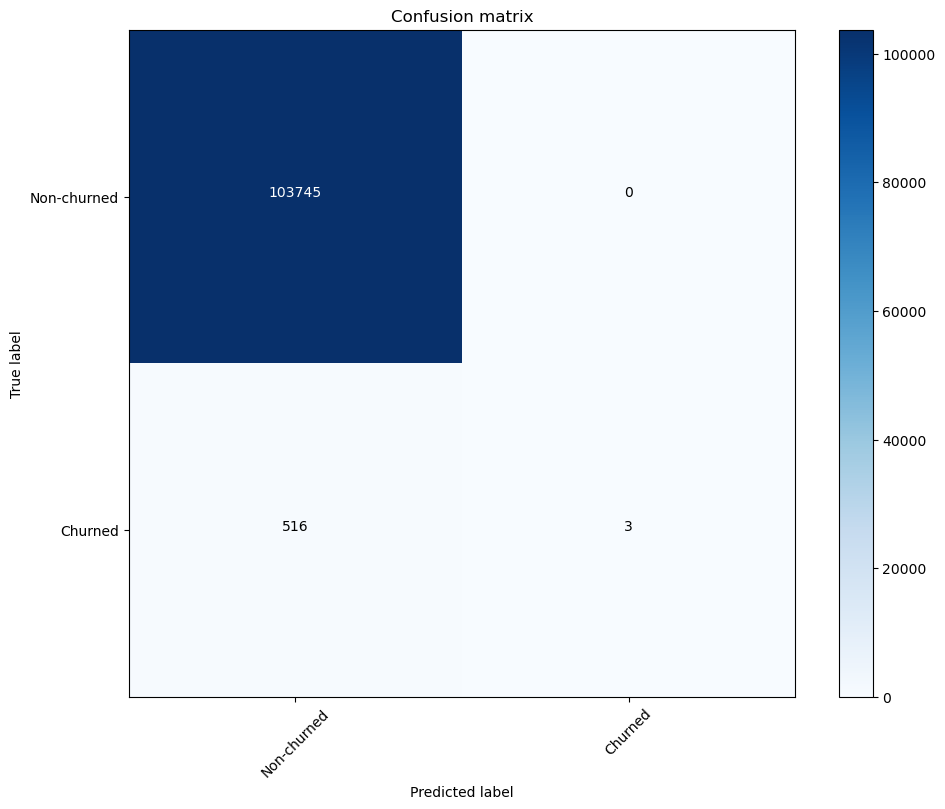

0    103745
1       519
Name: TARGET, dtype: int64

In [176]:
cnf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()


Модель достигла точности свыше 99%, однако в данном случае это совсем не говорит об успехе. Нас интересует показатель recall, который катастрофически мал, а из интересующих нас 519 единиц, верно предсказаны были только 3. Такая картина как раз и возникает, если обучать алгоритм в лоб, без решения проблемы балансировки данных.
Теперь воспользуемся одним из вариантов решения проблемы несбалансированности классов: присвоим большие веса минорной метке и начнем сильнее штрафовать модель за неправильный прогноз для единиц.

In [177]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 100

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)  # weights added
dtest = xgb.DMatrix(X_test)

In [ ]:
watchlist = [(dtrain, "train")]
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)

Confusion matrix, without normalization
[[98043  5702]
 [  313   206]]


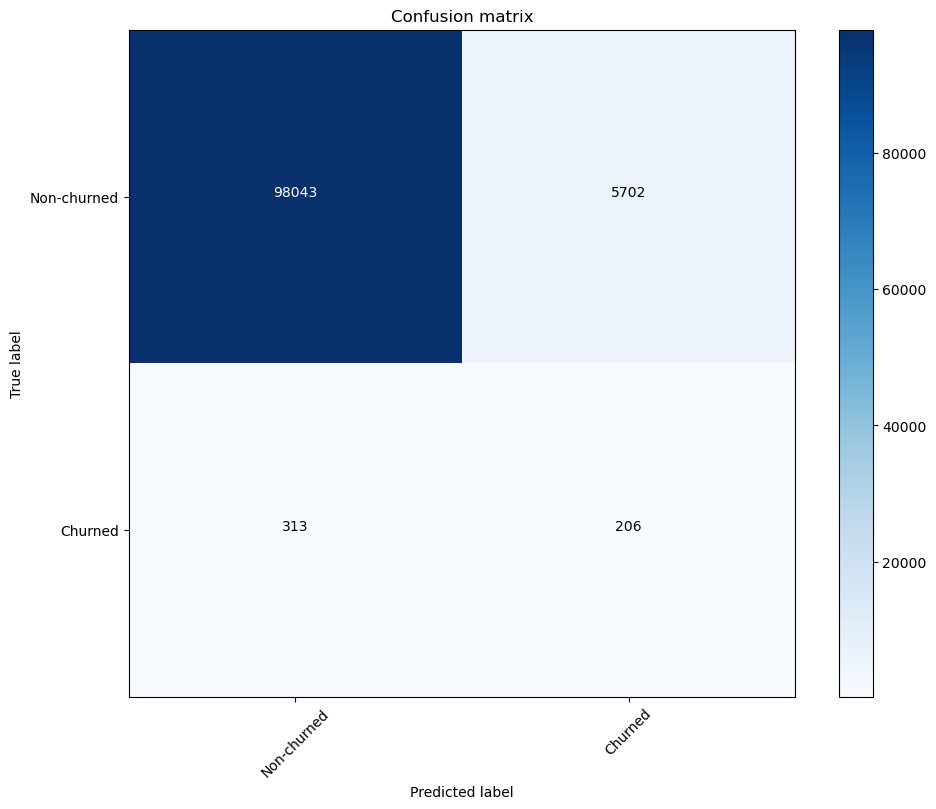

0    103745
1       519
Name: TARGET, dtype: int64

In [179]:
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()
y_test.value_counts()

Как можно заметить, присваивание больших весов минорному классу, положительно влияет на точность прогноза. Займемся более точной настройкой модели. Для этого воспользуемся кросс валидацией и перебором гиперпараметров методом RandomizedSearchCV.


In [297]:
param_grid = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "eta": [0.5, 0.6, 0.4, 0.55] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": [8, 9, 10],
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [0.05, 0.1, 0.15, 0.2],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "alpha": [ 0.5, 1, 1.5, 2],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "lambda": [ 5, 10, 25, 50],
    "objective": ["binary:logistic"],
    "eval_metric": ["logloss"],
    'scale_pos_weight': [180, 190, 200, 210, 220]}
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(tree_method= 'gpu_hist'),
                           param_distributions=param_grid,
                           n_iter=60,
                           scoring=scoring,
                           refit='recall',
                           cv=kfold,
                           verbose=8000)
# Fit grid search
random_result = random_search.fit(X_train, y_train)


In [ ]:
# Print grid search summary
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

In [35]:
opbest = {'objective': 'binary:logistic', 'max_depth': 15, 'lambda': 10, 'gamma': 0.001, 'eval_metric': 'logloss', 'eta': 0.4, 'colsample_bytree': 0.6, 'alpha': 1,'tree_method': 'gpu_hist', 'max_delta_step':0.4 }

In [ ]:
%%time
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 220
num_rounds = 290



dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, "train")]
xgb_model = xgb.train(opbest, dtrain, num_rounds, watchlist)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")


In [ ]:
quality_metrics(y_test, y_test_preds)
cnf_matrix = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()

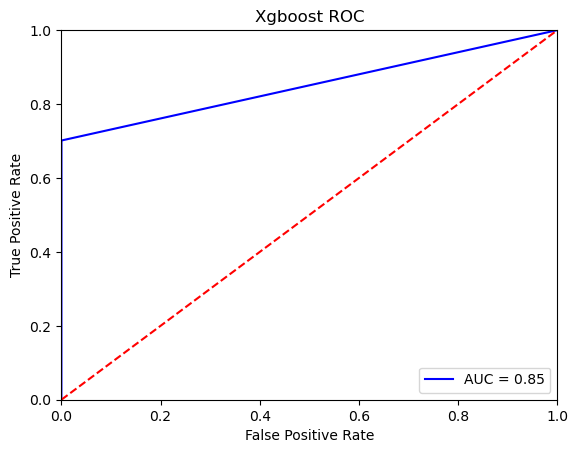

Коэффициент Джини: 0.701


In [50]:
probs =(xgb_model.predict(dtest) > 0.5).astype("int")
preds = probs
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Xgboost ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(f'Коэффициент Джини: {round(2*roc_auc-1, 3)}')

Как видно выше, наилучшие результаты показала модель, обучаемая на датасете без преобразований. Грамотная настройка модели позволила достичь хороших показателей качества классификации. Примем эту модель за эталонную и будем сравнивать ее с двумя другими алгоритмами градиентного бустинга.

## 6) CatBoost

In [20]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)

In [27]:
# Define the search space
param_grid = {"iterations":[1800, 1900, 2000],
              'eval_metric': ['Recall', 'Logloss', 'F1', 'TotalF1', 'Kappa', 'WKappa'],
              'grow_policy': [ 'Depthwise' , 'Lossguide'],
              'bootstrap_type': ['Poisson','Bernoulli'],
              'sampling_frequency': ['PerTree'],
              'min_data_in_leaf': [1, 2, 3],
              'subsample': [0.3, 0.5, 0.7],
              'leaf_estimation_method': ['Gradient'],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
              "depth": range(3, 21, 3),
              'random_strength': [0.7, 0.6, 0.8, 0.1],
              'boosting_type': ['Plain'],
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
              'auto_class_weights': ['Balanced', 'SqrtBalanced']}
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
ct= cat.CatBoostClassifier(task_type="GPU",loss_function='Logloss',eval_metric='Logloss')

random_search = ct.randomized_search(param_distributions=param_grid,
                                     X=X_train,
                                     y=y_train,
                                     cv=kfold,
                                     n_iter=70,
                                     verbose=1,
                                     plot=True)

In [ ]:
print("best params:\n", ct.get_params())

In [ ]:
%%time
params = {'loss_function': 'Logloss',
          'eval_metric': 'Recall', #Recall, Logloss, F1, TotalF1, Kappa, WKappa
          'task_type': 'GPU',
          'min_data_in_leaf': 0.1,
          'depth': 12,
          'iterations': 2900,
          'subsample': 0.5,
          'random_strength': 0.6,
          'learning_rate': 0.005,
          'l2_leaf_reg': 1e-05,
          'grow_policy': 'Depthwise',
          'boosting_type': 'Plain',
          'sampling_frequency': 'PerTree',
          'auto_class_weights': 'SqrtBalanced',
          'leaf_estimation_method': 'Gradient',
          'bootstrap_type': 'Bernoulli'}
model_n = cat.CatBoostClassifier(**params,verbose=True)
#train model
model_n.fit(X_train, y_train, eval_set=(X_test, y_test),

                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=True)
y_cb = model_n.predict(X_test)

In [ ]:
quality_metrics(y_test, y_cb)

Confusion matrix, without normalization
[[103734     11]
 [   155    364]]


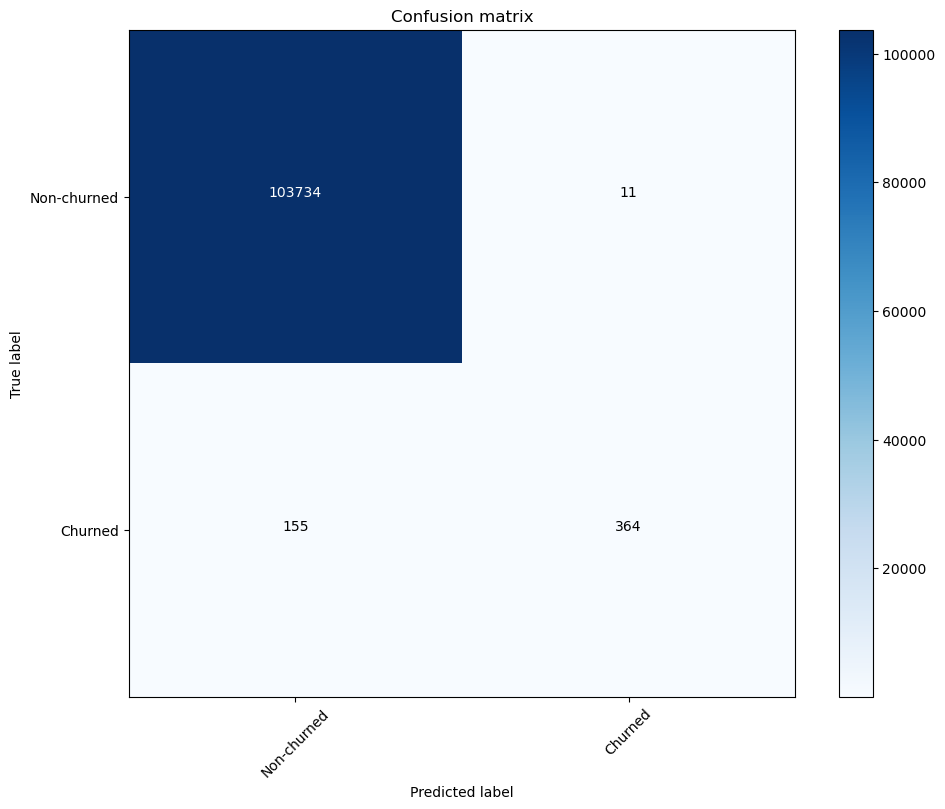

In [73]:
cnf_matrix = confusion_matrix(y_test, y_cb)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()

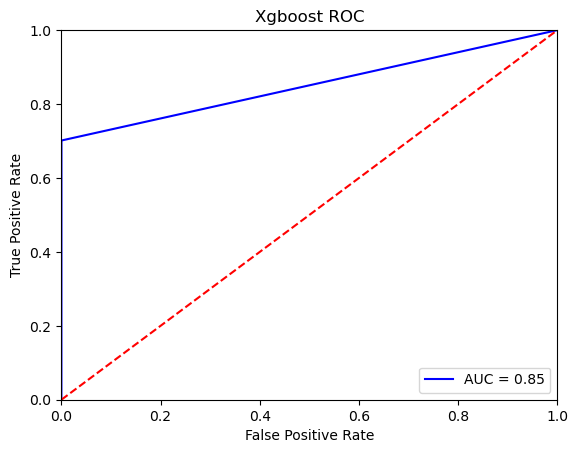

Коэффициент Джини: 0.701


In [74]:
probs =y_cb
preds = probs
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Catboost ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(f'Коэффициент Джини: {round(2*roc_auc-1, 3)}')

Catboost показал результат чуть лучше, чем Xgboost, но разница не велика.

## 7) LightGBM

In [20]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


In [31]:
param_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    'num_leaves': [31,62,150, 310],
    'boosting_type' : ['gbdt','rf', 'dart'],
    'subsample' : [0.3, 0.5,0.7],
    'min_split_gain' : [i / 50.0 for i in range(0, 5)],
    'min_data_in_leaf':[10, 20, 30, 40],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7],
    "objective": ["binary"],
    'metric':['binary_logloss', 'fair', 'auc'],
    'max_bin': [200, 255, 300, 350],
    'scale_pos_weight':[100, 150, 200, 220],
    'min_child_weight': [0.0001, 0.001, 0.01, 0.1],
    'min_child_samples': [15, 20, 30, 40],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    'data_sample_strategy': ['bagging', 'goss'],
    'num_iterations':[200, 400, 600]}

# Set up score
scoring = ['f1']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=LGBMClassifier(),
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   scoring=scoring,
                                   refit='f1',
                                   cv=kfold)
# Fit grid search
random_result = random_search.fit(X_train, y_train)

In [33]:
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is',
      round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.3003
The best score standard deviation is 0.0406
The best hyperparameters are {'subsample': 0.5, 'scale_pos_weight': 100, 'reg_lambda': 1, 'reg_alpha': 10, 'objective': 'binary', 'num_leaves': 62, 'num_iterations': 600, 'min_split_gain': 0.04, 'min_data_in_leaf': 30, 'min_child_weight': 0.0001, 'min_child_samples': 40, 'metric': 'auc', 'max_bin': 300, 'learning_rate': 0.1, 'data_sample_strategy': 'goss', 'colsample_bytree': 0.6, 'boosting_type': 'dart'}


C:\Users\777\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=30
Accuracy: 0.997045960
Precision: 0.697936210
Recall: 0.716763006
F1: 0.707224335
Confusion matrix, without normalization
[[103584    161]
 [   147    372]]


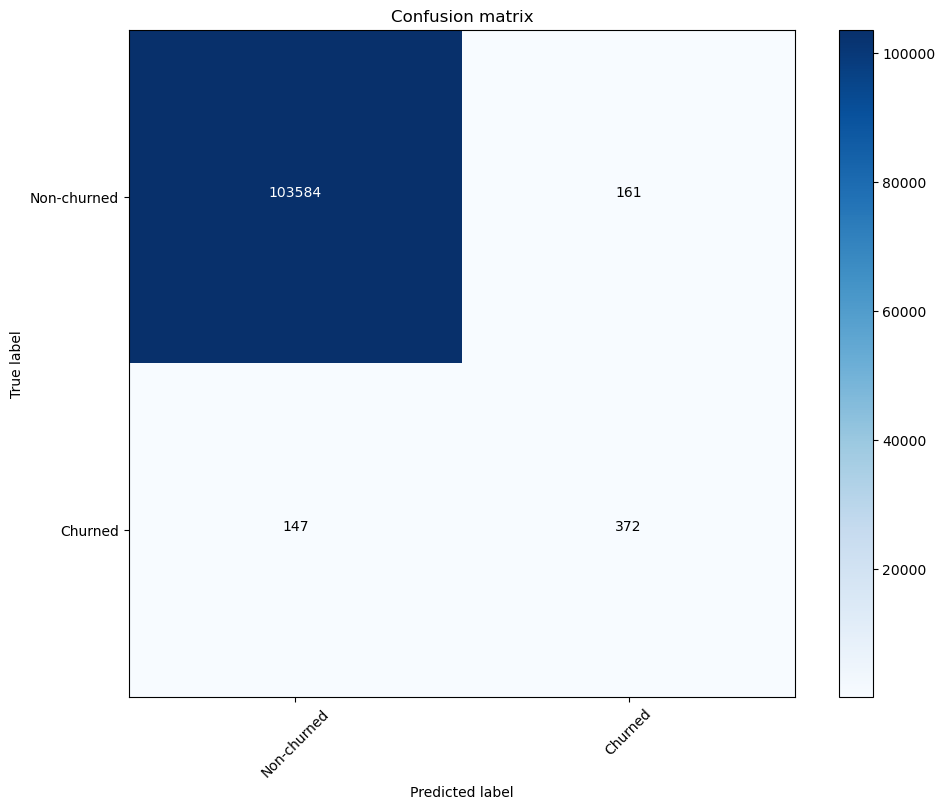

Wall time: 20.2 s


In [75]:
%%time
clf = LGBMClassifier(subsample=0.3, scale_pos_weight=130, reg_lambda=100, reg_alpha=10, objective='binary', num_leaves=200, num_iterations=1200, min_split_gain=0.01, min_data_in_leaf=30, metric='binary_logloss',min_child_weight= 0.001,min_child_samples=50, max_bin=300, learning_rate=0.1, colsample_bytree= 0.6, boosting_type='gbdt')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
quality_metrics(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()

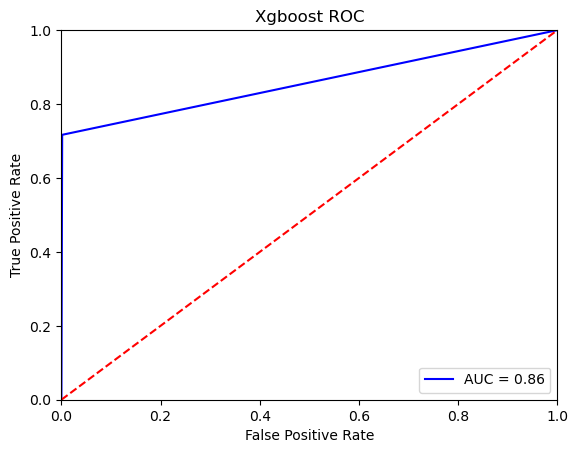

Коэффициент Джини: 0.715


In [76]:
probs =y_pred
preds = probs
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Lightgbm ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(f'Коэффициент Джини: {round(2*roc_auc-1, 3)}')

Lightgbm немного лучше классифицирует единицы, но хуже нули.

## 8) Выводы

In [79]:
df = pd.DataFrame({"Алгоритм":["Xgboost", "Catboost", "Lightgbm"], "Accuracy":["99,8%", "99,8%","99,7%"], "Precison":["96,66%", "97%","69,8%"], "Recall":["70,1%", "70,1%","71.7%"], "f1":["81,3%", "81,4%", "70,7%"],"AUC score":['0.85', '0.85', '0.86'], "Gini":['0.701', '0.701', '0.715'], "Время обучения, с": ["4.95", "205", "20.2"]})
print(df.to_markdown(index=False))

| Алгоритм   | Accuracy   | Precison   | Recall   | f1    |   AUC score |   Gini |   Время обучения, с |
|:-----------|:-----------|:-----------|:---------|:------|------------:|-------:|--------------------:|
| Xgboost    | 99,8%      | 96,66%     | 70,1%    | 81,3% |        0.85 |  0.701 |                4.95 |
| Catboost   | 99,8%      | 97%        | 70,1%    | 81,4% |        0.85 |  0.701 |              205    |
| Lightgbm   | 99,7%      | 69,8%      | 71.7%    | 70,7% |        0.86 |  0.715 |               20.2  |


Для задачи сравнения я обучал модели на исходном наборе данных без методов oversampling и undersampling, т.к за оптимальную модель Xgboost была принята модель, обучавшаяся именно на исходной выборке.
Методы преобразования данных сильно ухудшали показатели качества классификации. Скорее всего, даже наивные методы, деформировали исходное распределение данных достаточно сильно, что приводило к низкому качеству классификации.

Обучая 3 разных модели на исходных данных, все алгоритмы показывают похожие результаты. Лучше всех себя показал Catboost, но он же требовал больше всего времени на обучение. Самым простым в плане настройки был алгоритм Xgboost. Catboost и Lightgbm имеют намного больше настраиваемых гиперпараметров, соответственно эти алгоритмы могут быть более гибко и глубоко настроены. Также Catboost и Lightgbm умеют очень хорошо работать с категориальными признаками.

Хотелось бы добавить, что Xgboost и Catboost интуитивно понятные и приятные в работе алгоритмы. Первый-засчет небольшого количества гиперпараметров, а второй из-за очень подробной и понятной документации. Также эти алгоритмы позволяют использовать графический ускоритель прямо из коробки. Lightgbm же потребовал от меня переустановки и пересборки интерпретатора, чем я заниматься не стал.

## ИНС

In [20]:
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary
import torch
import torch.utils.data as data_utils
import time
from pytorch_tabnet.tab_model import TabNetClassifier

device = "cuda"

class MyDataset(data_utils.Dataset):

  def __init__(self, df):

    x=df.iloc[:,0:387].values
    y=df.iloc[:,387].values

    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int64)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


In [21]:
targ = train['TARGET']
train.drop(labels=['TARGET'], axis=1,inplace = True)
train.insert(387, 'TARGET', targ)
train

,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Subproduct_1,Subproduct_2,Subproduct_3,Subproduct_4,...,Factor_137,Factor_136,Factor_135,Factor_134,Factor_143,Factor_35_is_NaN,Factor_42_is_NaN,Factor_132_is_NaN,Factor_133_is_NaN,TARGET
0,0,0,0,1,0,0,0,0,0,0,...,1.0,2.0,2.0,36,36,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,3.0,1.0,3.0,60,60,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,4.0,12.0,11.0,60,60,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,5.0,13.0,13.0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,6.0,13.0,13.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282148,1,0,0,0,0,0,0,0,0,0,...,3.0,13.0,13.0,0,0,0,1,0,0,0
282149,0,0,0,1,0,0,0,0,0,0,...,9.0,2.0,2.0,36,36,0,0,0,0,0
282150,0,0,0,0,0,1,0,0,0,0,...,3.0,3.0,1.0,0,0,0,1,0,0,0
282151,0,0,0,1,0,1,0,0,0,0,...,5.0,12.0,1.0,60,0,0,0,0,0,0


In [22]:
targ = test['TARGET']
test.drop(labels=['TARGET'], axis=1,inplace = True)
test.insert(387, 'TARGET', targ)
test

,Product_1,Product_2,Product_3,Product_4,Product_5,Product_6,Subproduct_1,Subproduct_2,Subproduct_3,Subproduct_4,...,Factor_137,Factor_136,Factor_135,Factor_134,Factor_143,Factor_35_is_NaN,Factor_42_is_NaN,Factor_132_is_NaN,Factor_133_is_NaN,TARGET
0,0,0,1,1,0,0,0,0,0,0,...,4.0,10.0,11.0,38,60,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,5.0,12.0,11.0,60,60,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,3.0,9.0,9.0,120,120,1,1,1,1,0
3,0,0,0,0,1,0,0,0,0,0,...,9.0,9.0,9.0,120,120,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,8.0,1.0,3.0,60,60,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104003,0,1,0,1,0,0,0,0,0,0,...,9.0,4.0,2.0,37,36,0,0,0,0,0
104004,0,0,0,1,0,0,0,0,0,0,...,5.0,12.0,11.0,60,60,0,0,0,0,0
104005,0,1,0,0,1,0,0,0,0,0,...,5.0,1.0,7.0,60,60,0,0,0,0,0
104006,0,0,0,0,1,0,0,0,0,0,...,4.0,1.0,3.0,60,60,0,0,0,0,0


In [27]:
my_test = MyDataset(test)
test_loader=DataLoader(my_test,batch_size=62,shuffle=False)

In [28]:
for i, (data, labels) in enumerate(test_loader):
  print(data.shape, labels.shape)
  print(data,labels)
  break;

torch.Size([62, 387]) torch.Size([62])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [29]:
_, counts = torch.unique(torch.tensor(train.TARGET), return_counts=True)
weis = counts.max() / counts
print("Weights:", weis)

Weights: tensor([  1.0000, 223.6441])


In [ ]:
weight_for_sampler = []
for l in train.TARGET:
    weight_for_sampler.append(weis[l].item())
sampler = WeightedRandomSampler(torch.tensor(weight_for_sampler), len(train))
my_train = MyDataset(train)
train_loader=DataLoader(my_train,batch_size=62, drop_last=True, sampler=sampler)
def show_class_balance(y, classes):
    _, counts = torch.unique(torch.tensor(y), return_counts=True)
    plt.bar(classes, counts)
    plt.ylabel("n_samples")
    plt.ylim([0, 75])
    plt.show()

batch_labels = []
for data, labels in train_loader:
    print(
        "labels:",
        labels.int().tolist(),
        "Classes in batch: ",
        torch.unique(labels, return_counts=True)[1].tolist(),
    )
    batch_labels.append(labels.tolist())

In [ ]:
show_class_balance(batch_labels, ["0","1"])

In [77]:
class NeuralNetwork(nn.Module):
    def __init__(self, activation=nn.LeakyReLU()):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = activation
        self.layers_stack = nn.Sequential(
            nn.Linear(387, 387*2),
            self.activation,
            nn.Linear(387*2, 387*3),
            nn.Dropout(0.6),
            self.activation,
            nn.Linear(387*3, 387),
            nn.Dropout(0.5),
            self.activation,
            nn.Linear(387, 387),
            nn.Dropout(0.7),
            self.activation,
            nn.Linear(387, 387),
            self.activation,
            nn.Linear(387, 387),
            nn.Dropout(0.5),
            self.activation,
            nn.Linear(387, 190),
            nn.Dropout(0.7),
            self.activation,
            nn.Linear(190, 190),
            nn.Dropout(0.6),
            self.activation,
            nn.Linear(190, 190),
            self.activation,
            nn.Linear(190, 95),
            self.activation,
            nn.Linear(95, 45),
            self.activation,
            nn.Linear(45, 45),
            self.activation,
            nn.Linear(45, 22),
            nn.Dropout(0.8),
            self.activation,
            nn.Linear(22, 10),
            self.activation,
            nn.Linear(10, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

In [78]:
model = NeuralNetwork().to(device)

In [79]:
summary(model, (1, 387))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 387]               0
            Linear-2                  [-1, 774]         300,312
         LeakyReLU-3                  [-1, 774]               0
         LeakyReLU-4                  [-1, 774]               0
            Linear-5                 [-1, 1161]         899,775
           Dropout-6                 [-1, 1161]               0
         LeakyReLU-7                 [-1, 1161]               0
         LeakyReLU-8                 [-1, 1161]               0
            Linear-9                  [-1, 387]         449,694
          Dropout-10                  [-1, 387]               0
        LeakyReLU-11                  [-1, 387]               0
        LeakyReLU-12                  [-1, 387]               0
           Linear-13                  [-1, 387]         150,156
          Dropout-14                  [

In [80]:
learning_rate = 0.0001
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [81]:
def train_loop(dataloader, model, loss_function, optimizer):
    global cortrain
    num_batches = len(dataloader)

    train_loss, corr_train = 0, 0
    cortrain = []
    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        corr_train += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortrain = corr_train* 100
    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    global cortest
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0
    cortest = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortest = correct * 100
    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [82]:
loss_history = {"train": [], "test": []}
start_time = time.time()
num_epochs = 20
cor_test = []
cor_train = []
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_loader, model, loss_function, optimizer)
    test_loss = test_loop(test_loader, model, loss_function)
    cor_test.append(cortest)
    cor_train.append(cortrain)
    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 0.715864
Потери на тестовых данных: 0.687474, Точность модели на тестовых данных: 82.1% 

Эпоха номер 2
Потери обучения: 0.689865
Потери на тестовых данных: 0.715553, Точность модели на тестовых данных: 70.6% 

Эпоха номер 3
Потери обучения: 0.633156
Потери на тестовых данных: 0.661854, Точность модели на тестовых данных: 77.8% 

Эпоха номер 4
Потери обучения: 0.602276
Потери на тестовых данных: 0.557132, Точность модели на тестовых данных: 73.4% 

Эпоха номер 5
Потери обучения: 0.580902
Потери на тестовых данных: 0.550357, Точность модели на тестовых данных: 67.1% 

Эпоха номер 6
Потери обучения: 0.561275
Потери на тестовых данных: 0.591196, Точность модели на тестовых данных: 64.3% 

Эпоха номер 7
Потери обучения: 0.536122
Потери на тестовых данных: 0.534860, Точность модели на тестовых данных: 68.8% 

Эпоха номер 8
Потери обучения: 0.512692
Потери на тестовых данных: 0.529995, Точность модели на тестовых данных: 71.2% 

Эпоха номер 9
Потери обучения: 0

In [83]:
cor_test_g = [x / 104008 for x in cor_test]
cor_train_g = [x / 282153 for x in cor_train]


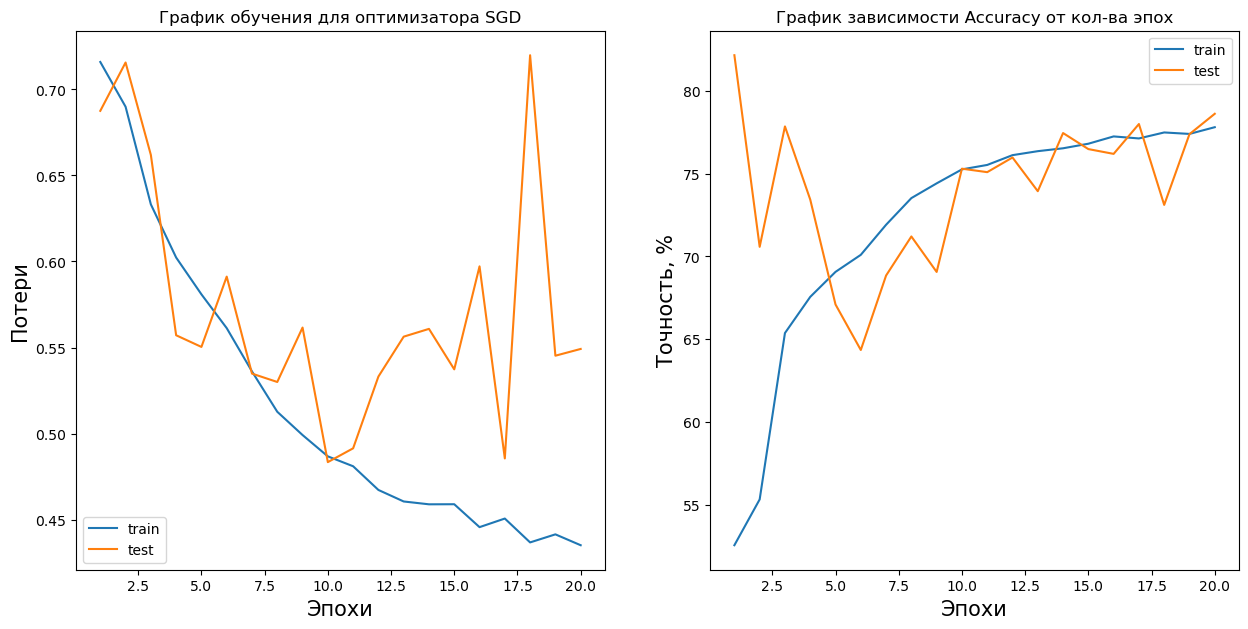

In [84]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.title("График обучения для оптимизатора SGD")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), cor_train_g, label="train")
plt.plot(range(1, num_epochs + 1), cor_test_g, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости Accuracy от кол-ва эпох")
plt.grid
plt.show()

Accuracy: 0.787391355
Precision: 0.018587527
Recall: 0.619760479
F1: 0.036092585
Confusion matrix, without normalization
[[81481 21859]
 [  254   414]]


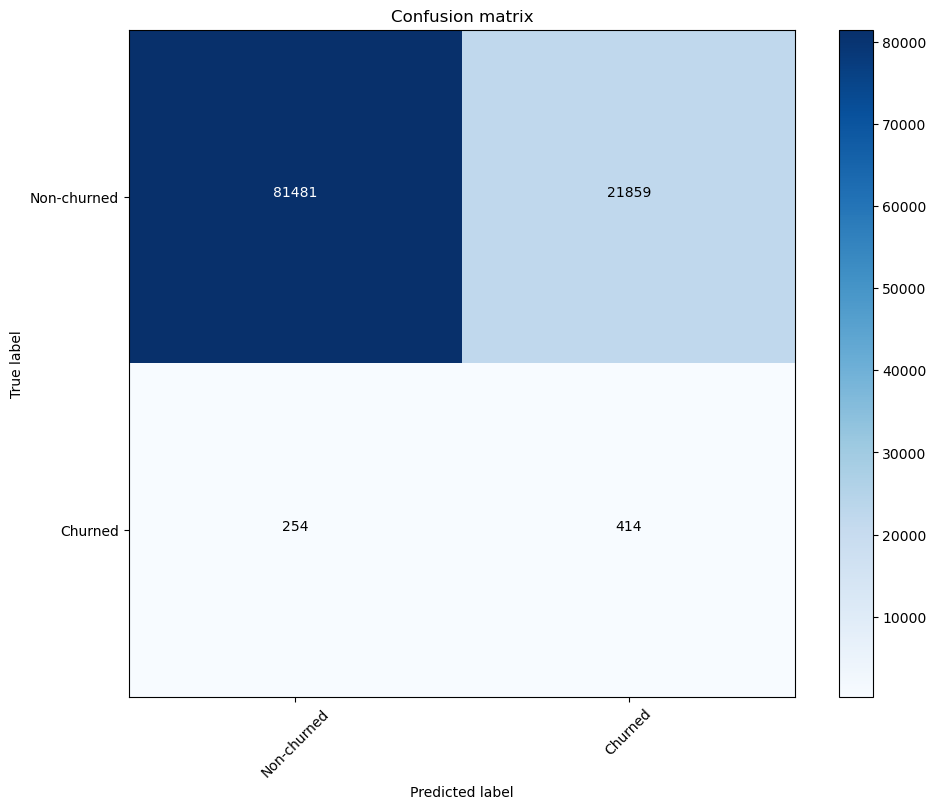

In [85]:
net = model.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        X, y = data
        output = net(X.view(-1, 387))
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
quality_metrics(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()

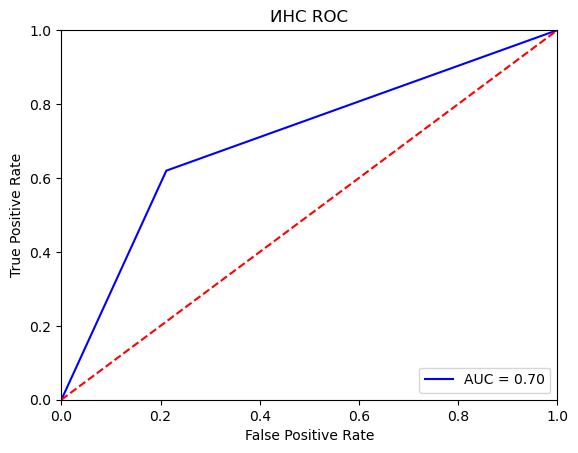

Коэффициент Джини: 0.408


In [86]:
probs =y_pred
preds = probs
fpr, tpr, threshold = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

plt.title('ИНС ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(f'Коэффициент Джини: {round(2*roc_auc-1, 3)}')

In [87]:
dataset = pd.concat([train, test], ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(
    dataset[features], dataset['TARGET'], test_size=0.27, stratify=dataset['TARGET'], random_state=123
)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
clf = TabNetClassifier(n_d=11, n_a=11,)
clf.fit(
  X_train.values, y_train,
  eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],max_epochs=15,batch_size=256, eval_name=['train', 'test'],
    eval_metric=['auc','logloss'],drop_last=False, weights={0:1, 1:180})

Accuracy: 0.975763447
Precision: 0.133576642
Recall: 0.705202312
F1: 0.224608776
Confusion matrix, without normalization
[[101371   2374]
 [   153    366]]


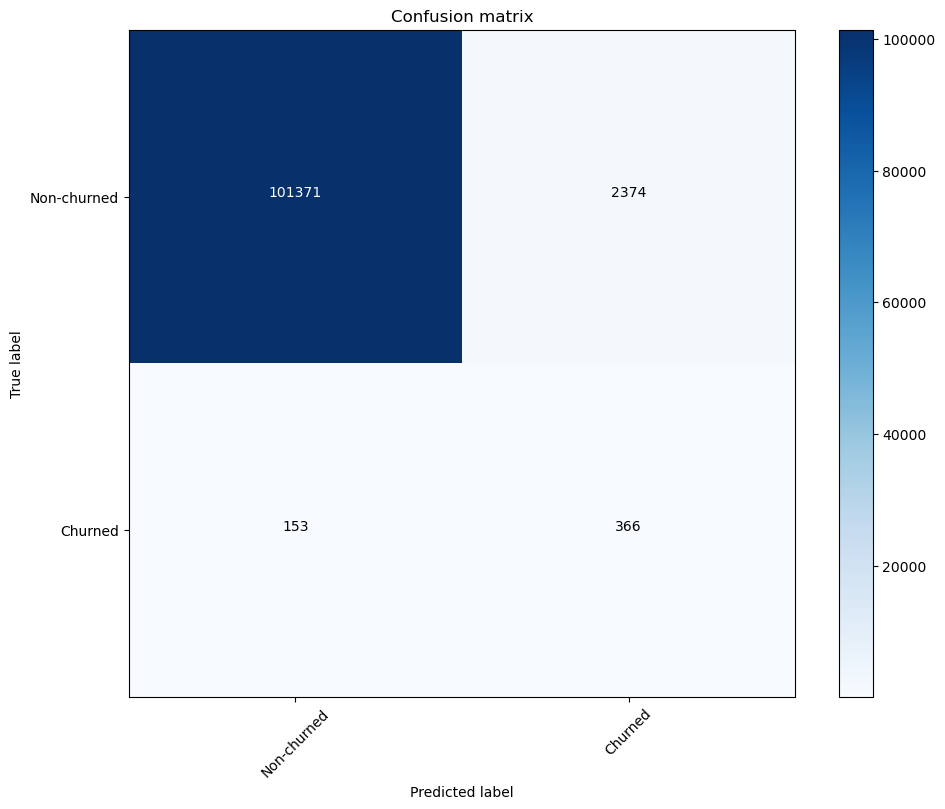

In [89]:
preds = clf.predict(X_test.values)
quality_metrics(y_test, preds)
cnf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.show()

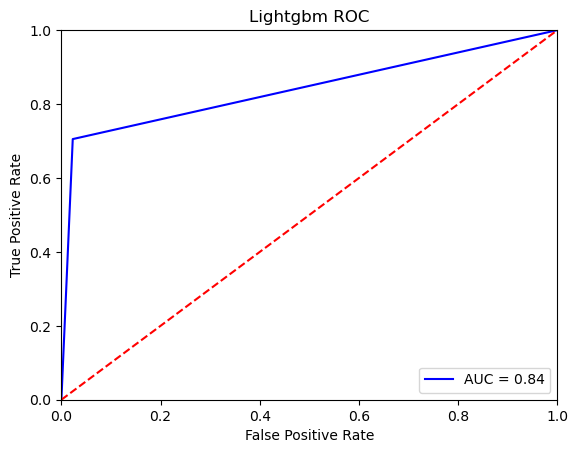

Коэффициент Джини: 0.682


In [90]:
probs =preds
preds = probs
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Lightgbm ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(f'Коэффициент Джини: {round(2*roc_auc-1, 3)}')